## Import

In [52]:
# ! python -m pip install -- upgrade pip 

import warnings 
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np 

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import ParameterGrid 
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score 
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier as LGBMC 
from lightgbm.sklearn import LGBMRegressor
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks 
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import ADASYN 

import matplotlib.pyplot as plt 

from tqdm import tqdm 

In [2]:
def y_label_count(df):
    colors = ['lightsteelblue', '#FD9F31'] #'#0E1F55'

    wedgeprops={'width': 0.7, 'edgecolor': 'k', 'linewidth': 0.75}

    plt.subplots(figsize = (8,8))
    plt.title('Ratio of Y_LABEL in Total Data', fontsize = 20, fontdict = {'weight': 'bold'})
    plt.rc('font', size=12)  
    labels = ['0', '1'] 
    plt.pie(df['Y_LABEL'].value_counts(), 
            autopct="%.2f%%", shadow = True, startangle = 90, textprops={'fontsize': 15},
            colors = colors, wedgeprops = wedgeprops, labels = labels)

    plt.tight_layout()
    plt.show()

    print('전체 데이터 수:', len(df['Y_LABEL']))
    print('전체 데이터 중 양품의 수: ', df['Y_LABEL'].value_counts()[0])
    print('전체 데이터 중 불량품의 수: ', df['Y_LABEL'].value_counts()[1])
        

## Data Load 및 간단한 전처리 

* train.csv 데이터만을 사용해서 진행 
* 문자열 데이터인 ID 제거 
* 결측치가 15%가 넘는 열 제거하기
* 문자열 데이터인 ID 및 COMPONENT_ARBITRARY 제거
* YEAR 변수 제거

In [3]:
#categorical_features=['COMPONENT_ARBITRARY']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = [ 'ANONYMOUS_1' ,'AG','FE', 'ANONYMOUS_2', 'CO', 'CR', 'CU', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']
AL_train_stage_features = ['AL', 'ANONYMOUS_1' ,'AG','FE', 'ANONYMOUS_2', 'CO', 'CR', 'CU', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']


In [4]:
raw_data=pd.read_csv('/content/drive/MyDrive/oil/train.csv')
raw_data_X=raw_data.drop(['ID','COMPONENT_ARBITRARY','YEAR','Y_LABEL'],axis=1)
raw_data_y=raw_data[['Y_LABEL']]


In [5]:
drop_columnlist=[]
for col in raw_data_X.columns:
  if raw_data_X[col].isnull().sum()/len(raw_data_X) > 0.15:
     drop_columnlist.append(col)

In [6]:
raw_data_X.isnull().sum()/len(raw_data_X)

ANONYMOUS_1            0.000000
SAMPLE_TRANSFER_DAY    0.000000
ANONYMOUS_2            0.000000
AG                     0.000000
AL                     0.000000
B                      0.000000
BA                     0.000000
BE                     0.000000
CA                     0.000000
CD                     0.098900
CO                     0.000000
CR                     0.000000
CU                     0.000000
FH2O                   0.724016
FNOX                   0.724016
FOPTIMETHGLY           0.724016
FOXID                  0.724016
FSO4                   0.724016
FTBN                   0.724016
FE                     0.000000
FUEL                   0.724016
H2O                    0.000000
K                      0.163107
LI                     0.000000
MG                     0.000000
MN                     0.000000
MO                     0.000000
NA                     0.000000
NI                     0.000000
P                      0.000000
PB                     0.000000
PQINDEX 

In [7]:
drop_columnlist

['FH2O',
 'FNOX',
 'FOPTIMETHGLY',
 'FOXID',
 'FSO4',
 'FTBN',
 'FUEL',
 'K',
 'SOOTPERCENTAGE',
 'U100',
 'U75',
 'U50',
 'U25',
 'U20',
 'U14',
 'U6',
 'U4',
 'V100']

In [8]:
# 결측률이 15%이상인 열들을 삭제한다.

raw_data_X=raw_data_X.drop(drop_columnlist,axis=1)

In [9]:
train_X,test_X,train_y,test_y=train_test_split(raw_data_X,raw_data_y,test_size=0.2,random_state=42,stratify=raw_data_y)
train_X,val_X,train_y,val_y=train_test_split(train_X,train_y,test_size=0.2,random_state=42,stratify=train_y) 

In [10]:
# 진단 테스트 상황 때는 Component Arbitrary' 와 'YEAR'를 제외한 16개 변수를 사용한다.

test_X_new=test_X.loc[:,test_stage_features]

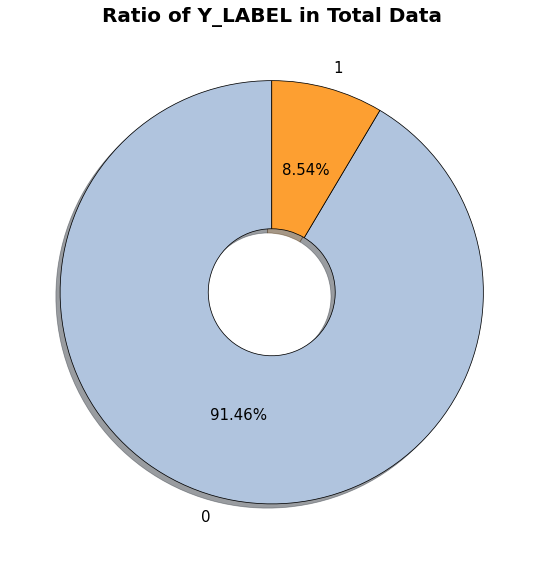

전체 데이터 수: 9020
전체 데이터 중 양품의 수:  8250
전체 데이터 중 불량품의 수:  770


In [11]:
y_label_count(train_y)

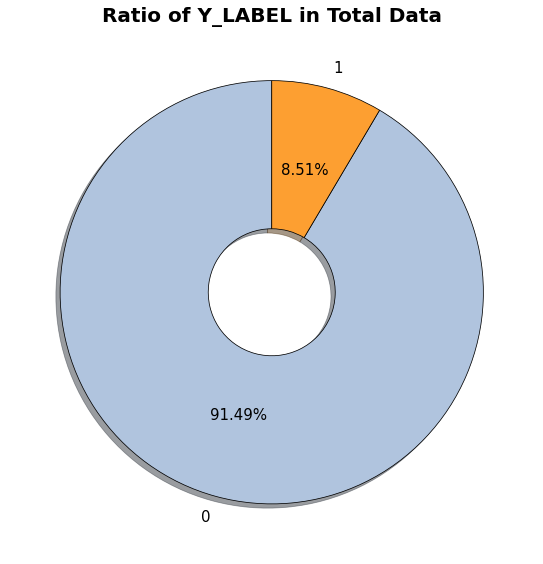

전체 데이터 수: 2256
전체 데이터 중 양품의 수:  2064
전체 데이터 중 불량품의 수:  192


In [12]:
y_label_count(val_y)

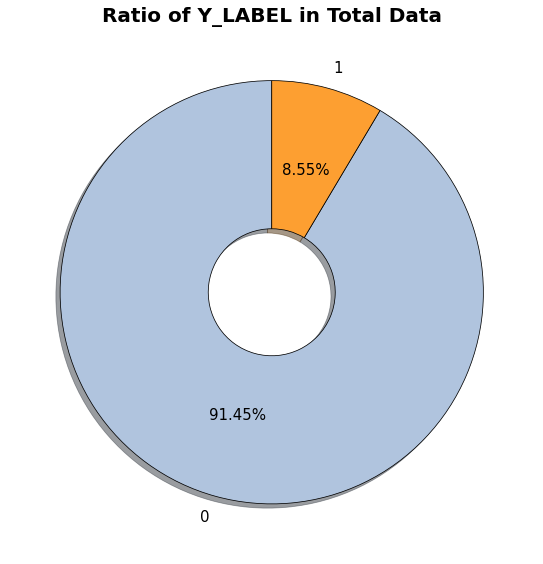

전체 데이터 수: 2819
전체 데이터 중 양품의 수:  2578
전체 데이터 중 불량품의 수:  241


In [13]:
y_label_count(test_y)

In [14]:

#le = LabelEncoder()
#for col in categorical_features:    
#    train_X[col] = le.fit_transform(train_X[col])
#    val_X[col] = le.transform(val_X[col])
#    if col in test_X_new.columns:
#        test_X_new[col] = le.transform(test_X_new[col])

In [15]:
min_max_scaler=MinMaxScaler()

train_x_sc_np=min_max_scaler.fit_transform(train_X)
train_x_sc=pd.DataFrame(train_x_sc_np,columns=train_X.columns)

val_x_sc_np=min_max_scaler.fit_transform(val_X)
val_x_sc=pd.DataFrame(val_x_sc_np,columns=val_X.columns)

test_x_sc_np=min_max_scaler.fit_transform(test_X_new)
test_x_sc=pd.DataFrame(test_x_sc_np,columns=test_X_new.columns)


## 모델 성능 지표 함수

In [16]:
def get_clf_eval(y_test, probability, threshold):
  pred=np.where(probability>threshold,1,0)
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred) 
  recall=recall_score(y_test,pred) 
  # F1 스코어 추가 
  f1=f1_score(y_test,pred, average='macro')
  print('임계값: ', threshold) 
  print('오차행렬')
  print(confusion) 
  # f1 score print 추가 
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy,precision,recall,f1))





   * 총 5개의 Case로 구분하여 불균형 데이터 샘플링 기법이 예측 성능 증가에 기여할 수 있는지 가볍게 살펴보고자 함.
   * 5개의 Case는 아래와 같음

| |Scale|Sampling|
|:-------:|:-------:|:--------:|
|Case 1| Min-Max Scaler | class weight |
|Case 2| Min-Max Scaler | SMOTE |
|Case 3| Min-Max Scaler | SMOTE-Tomek|
|Case 4| Min-Max Scaler | ADASYN|
|Case 5| Min-Max Scaler | RandomUndersampling|


   *  LightGBMClassifier를 Teacher model로, LightGBMRegressor를 Student model로 사용하고 어느 샘플링기법이 효과적인지를 알기 위해 파라미터는 같은 값으로 설정함
   * 성능지표는 Macro F1 Score를 사용.

## Case 1

* Teacher Model LightGBMClassifier 모델 만들기
* Class Imbalance 문제를 해결하기 위해 LightGBMClassifier 모델에 class weight를 적용하였다.

In [17]:
# 불량과 정상의 비율의 비를 구하고 모델 LightGBM에 class_weight를 적용하기

ratio=train_y.value_counts()[0]/train_y.value_counts()[1]
lgbm_classweight=LGBMC(max_depth=10, n_estimators=700, num_leaves=1600, subsample=0.8, random_state=42,scale_pos_weight=ratio)

train_x_sc=train_x_sc.loc[:,AL_train_stage_features]
lgbm_classweight.fit(train_x_sc,train_y)


LGBMClassifier(max_depth=10, n_estimators=700, num_leaves=1600, random_state=42,
               scale_pos_weight=10.714285714285714, subsample=0.8)

In [18]:
# 예측값의 불량일 확률값을 train_new_probab 데이터프레임에 저장하기 

train_new_probab=pd.DataFrame()
train_new_probab['Prob']=lgbm_classweight.predict_proba(train_x_sc)[:,1]

* Student Model LigthGBMRegressor 모델 만들기


In [19]:
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1,random_state=42)

In [20]:
val_prob=pd.DataFrame()
train_new_x_sc=train_x_sc.loc[:,test_stage_features]
val_new_x_sc=val_x_sc.loc[:,test_stage_features]
lgbm_reg.fit(train_new_x_sc, train_new_probab['Prob'])
val_prob['Prob_case1']=lgbm_reg.predict(val_new_x_sc)

In [21]:
thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for threshold in thresholds:
  get_clf_eval(val_y['Y_LABEL'],val_prob['Prob_case1'],threshold)

임계값:  0.3
오차행렬
[[1767  297]
 [ 151   41]]
정확도: 0.8014, 정밀도: 0.1213, 재현율: 0.2135, F1:0.5211
임계값:  0.35
오차행렬
[[1885  179]
 [ 166   26]]
정확도: 0.8471, 정밀도: 0.1268, 재현율: 0.1354, F1:0.5236
임계값:  0.4
오차행렬
[[1955  109]
 [ 176   16]]
정확도: 0.8737, 정밀도: 0.1280, 재현율: 0.0833, F1:0.5165
임계값:  0.45
오차행렬
[[2008   56]
 [ 186    6]]
정확도: 0.8927, 정밀도: 0.0968, 재현율: 0.0312, F1:0.4952
임계값:  0.5
오차행렬
[[2028   36]
 [ 188    4]]
정확도: 0.9007, 정밀도: 0.1000, 재현율: 0.0208, F1:0.4911
임계값:  0.55
오차행렬
[[2046   18]
 [ 188    4]]
정확도: 0.9087, 정밀도: 0.1818, 재현율: 0.0208, F1:0.4947
임계값:  0.6
오차행렬
[[2052   12]
 [ 189    3]]
정확도: 0.9109, 정밀도: 0.2000, 재현율: 0.0156, F1:0.4911


## Test data 

In [22]:
test_prob=pd.DataFrame()

test_prob['Case1']=lgbm_reg.predict(test_x_sc)
for threshold in thresholds:
  get_clf_eval(test_y['Y_LABEL'],test_prob['Case1'],threshold)

임계값:  0.3
오차행렬
[[2334  244]
 [ 196   45]]
정확도: 0.8439, 정밀도: 0.1557, 재현율: 0.1867, F1:0.5418
임계값:  0.35
오차행렬
[[2441  137]
 [ 220   21]]
정확도: 0.8734, 정밀도: 0.1329, 재현율: 0.0871, F1:0.5186
임계값:  0.4
오차행렬
[[2497   81]
 [ 232    9]]
정확도: 0.8890, 정밀도: 0.1000, 재현율: 0.0373, F1:0.4977
임계값:  0.45
오차행렬
[[2527   51]
 [ 236    5]]
정확도: 0.8982, 정밀도: 0.0893, 재현율: 0.0207, F1:0.4900
임계값:  0.5
오차행렬
[[2550   28]
 [ 239    2]]
정확도: 0.9053, 정밀도: 0.0667, 재현율: 0.0083, F1:0.4825
임계값:  0.55
오차행렬
[[2563   15]
 [ 239    2]]
정확도: 0.9099, 정밀도: 0.1176, 재현율: 0.0083, F1:0.4841
임계값:  0.6
오차행렬
[[2570    8]
 [ 241    0]]
정확도: 0.9117, 정밀도: 0.0000, 재현율: 0.0000, F1:0.4769


## Case 2 
* Teacher Model LightGBMClassifier 모델 만들기
* Class Imbalance 문제를 해결하기 위해 LightGBMClassifier 모델에 Smote sampling기법을 적용하였다.

In [26]:

raw_data=pd.read_csv('/content/drive/MyDrive/oil/train.csv')
raw_data_X=raw_data.drop(['ID','COMPONENT_ARBITRARY','YEAR','Y_LABEL'],axis=1)
raw_data_y=raw_data[['Y_LABEL']]

train_X,test_X,train_y,test_y=train_test_split(raw_data_X,raw_data_y,test_size=0.2,random_state=42,stratify=raw_data_y)
train_X,val_X,train_y,val_y=train_test_split(train_X,train_y,test_size=0.2,random_state=42,stratify=train_y)
train_X=train_X.loc[:,AL_train_stage_features]
test_X_new=test_X.loc[:,test_stage_features]

min_max_scaler=MinMaxScaler() 
train_x_sc_np=min_max_scaler.fit_transform(train_X) 
train_x_sc=pd.DataFrame(train_x_sc_np,columns=train_x_sc.columns) 

val_x_sc_np=min_max_scaler.fit_transform(val_X)
val_x_sc=pd.DataFrame(val_x_sc_np,columns=val_X.columns)

test_x_sc_np=min_max_scaler.fit_transform(test_X_new)
test_x_sc=pd.DataFrame(test_x_sc_np,columns=test_X_new.columns)

x_smote,y_smote=SMOTE(random_state=42).fit_resample(train_x_sc,train_y)

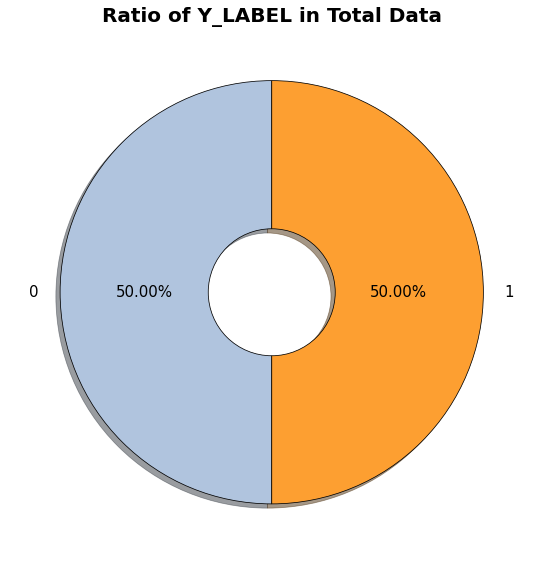

전체 데이터 수: 16500
전체 데이터 중 양품의 수:  8250
전체 데이터 중 불량품의 수:  8250


In [27]:
y_label_count(y_smote)

In [28]:
lgbm = LGBMC(max_depth= 10, n_estimators= 700, num_leaves= 1600, subsample= 0.8, random_state=42)
lgbm.fit(x_smote, y_smote)

LGBMClassifier(max_depth=10, n_estimators=700, num_leaves=1600, random_state=42,
               subsample=0.8)

In [30]:
train_new_probab=pd.DataFrame()
train_new_probab['Prob']=lgbm.predict_proba(x_smote)[:,1]

* Student Model LigthGBMRegressor 모델 만들기


In [32]:
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1,random_state=42)

In [34]:
val_prob=pd.DataFrame()
train_new_x_sc=x_smote.loc[:,test_stage_features]
val_new_x_sc=val_x_sc.loc[:,test_stage_features]
lgbm_reg.fit(train_new_x_sc, train_new_probab['Prob'])
val_prob['Prob_case2']=lgbm_reg.predict(val_new_x_sc)

In [35]:
thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for threshold in thresholds:
  get_clf_eval(val_y['Y_LABEL'],val_prob['Prob_case2'],threshold)

임계값:  0.3
오차행렬
[[ 266 1798]
 [  17  175]]
정확도: 0.1955, 정밀도: 0.0887, 재현율: 0.9115, F1:0.1942
임계값:  0.35
오차행렬
[[ 393 1671]
 [  22  170]]
정확도: 0.2496, 정밀도: 0.0923, 재현율: 0.8854, F1:0.2422
임계값:  0.4
오차행렬
[[ 534 1530]
 [  27  165]]
정확도: 0.3098, 정밀도: 0.0973, 재현율: 0.8594, F1:0.2909
임계값:  0.45
오차행렬
[[ 728 1336]
 [  46  146]]
정확도: 0.3874, 정밀도: 0.0985, 재현율: 0.7604, F1:0.3437
임계값:  0.5
오차행렬
[[ 940 1124]
 [  69  123]]
정확도: 0.4712, 정밀도: 0.0986, 재현율: 0.6406, F1:0.3914
임계값:  0.55
오차행렬
[[1179  885]
 [  97   95]]
정확도: 0.5647, 정밀도: 0.0969, 재현율: 0.4948, F1:0.4341
임계값:  0.6
오차행렬
[[1436  628]
 [ 115   77]]
정확도: 0.6707, 정밀도: 0.1092, 재현율: 0.4010, F1:0.4831


## Test

In [36]:
test_prob=pd.DataFrame()

test_prob['Case2']=lgbm_reg.predict(test_x_sc)
for threshold in thresholds:
  get_clf_eval(test_y['Y_LABEL'],test_prob['Case2'],threshold)

임계값:  0.3
오차행렬
[[ 245 2333]
 [  20  221]]
정확도: 0.1653, 정밀도: 0.0865, 재현율: 0.9170, F1:0.1652
임계값:  0.35
오차행렬
[[ 355 2223]
 [  30  211]]
정확도: 0.2008, 정밀도: 0.0867, 재현율: 0.8755, F1:0.1987
임계값:  0.4
오차행렬
[[ 493 2085]
 [  44  197]]
정확도: 0.2448, 정밀도: 0.0863, 재현율: 0.8174, F1:0.2363
임계값:  0.45
오차행렬
[[ 665 1913]
 [  62  179]]
정확도: 0.2994, 정밀도: 0.0856, 재현율: 0.7427, F1:0.2779
임계값:  0.5
오차행렬
[[ 897 1681]
 [  79  162]]
정확도: 0.3757, 정밀도: 0.0879, 재현율: 0.6722, F1:0.3301
임계값:  0.55
오차행렬
[[1135 1443]
 [ 102  139]]
정확도: 0.4519, 정밀도: 0.0879, 재현율: 0.5768, F1:0.3738
임계값:  0.6
오차행렬
[[1382 1196]
 [ 118  123]]
정확도: 0.5339, 정밀도: 0.0933, 재현율: 0.5104, F1:0.4177


## Case 3

* Teacher Model LightGBMClassifier 모델 만들기
* Class Imbalance 문제를 해결하기 위해 LightGBMClassifier 모델에 SMOTETomek sampling기법을 적용하였다.

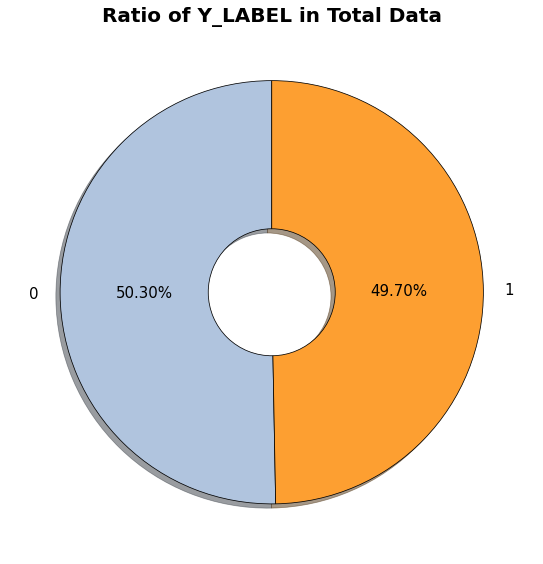

전체 데이터 수: 16403
전체 데이터 중 양품의 수:  8153
전체 데이터 중 불량품의 수:  8250


In [38]:

raw_data=pd.read_csv('/content/drive/MyDrive/oil/train.csv')
raw_data_X=raw_data.drop(['ID','COMPONENT_ARBITRARY','YEAR','Y_LABEL'],axis=1)
raw_data_y=raw_data[['Y_LABEL']]

train_X,test_X,train_y,test_y=train_test_split(raw_data_X,raw_data_y,test_size=0.2,random_state=42,stratify=raw_data_y)
train_X,val_X,train_y,val_y=train_test_split(train_X,train_y,test_size=0.2,random_state=42,stratify=train_y)
train_X=train_X.loc[:,AL_train_stage_features]
test_X_new=test_X.loc[:,test_stage_features]

min_max_scaler=MinMaxScaler() 
train_x_sc_np=min_max_scaler.fit_transform(train_X) 
train_x_sc=pd.DataFrame(train_x_sc_np,columns=train_x_sc.columns) 

val_x_sc_np=min_max_scaler.fit_transform(val_X)
val_x_sc=pd.DataFrame(val_x_sc_np,columns=val_X.columns)

test_x_sc_np=min_max_scaler.fit_transform(test_X_new)
test_x_sc=pd.DataFrame(test_x_sc_np,columns=test_X_new.columns)

smoteto=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

x_tomek,y_tomek=smoteto.fit_resample(train_x_sc,train_y)

y_label_count(y_tomek)

In [39]:
lgbm=LGBMC(max_depth=10, n_estimators=700, num_leaves=1600, subsample=0.8, random_state=42) 
lgbm.fit(x_tomek,y_tomek)

LGBMClassifier(max_depth=10, n_estimators=700, num_leaves=1600, random_state=42,
               subsample=0.8)

In [40]:
train_new_probab=pd.DataFrame()
train_new_probab['Prob']=lgbm.predict_proba(x_tomek)[:,1]

* Student Model LigthGBMRegressor 모델 만들기


In [41]:
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1,random_state=42)

In [42]:
val_prob=pd.DataFrame()
train_new_x_sc=x_tomek.loc[:,test_stage_features]
val_new_x_sc=val_x_sc.loc[:,test_stage_features]
lgbm_reg.fit(train_new_x_sc, train_new_probab['Prob'])
val_prob['Prob_case3']=lgbm_reg.predict(val_new_x_sc)

In [43]:
thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for threshold in thresholds:
  get_clf_eval(val_y['Y_LABEL'],val_prob['Prob_case3'],threshold)

임계값:  0.3
오차행렬
[[ 326 1738]
 [  16  176]]
정확도: 0.2225, 정밀도: 0.0920, 재현율: 0.9167, F1:0.2191
임계값:  0.35
오차행렬
[[ 443 1621]
 [  24  168]]
정확도: 0.2708, 정밀도: 0.0939, 재현율: 0.8750, F1:0.2598
임계값:  0.4
오차행렬
[[ 606 1458]
 [  34  158]]
정확도: 0.3387, 정밀도: 0.0978, 재현율: 0.8229, F1:0.3115
임계값:  0.45
오차행렬
[[ 793 1271]
 [  56  136]]
정확도: 0.4118, 정밀도: 0.0967, 재현율: 0.7083, F1:0.3573
임계값:  0.5
오차행렬
[[1016 1048]
 [  77  115]]
정확도: 0.5013, 정밀도: 0.0989, 재현율: 0.5990, F1:0.4067
임계값:  0.55
오차행렬
[[1260  804]
 [ 103   89]]
정확도: 0.5980, 정밀도: 0.0997, 재현율: 0.4635, F1:0.4497
임계값:  0.6
오차행렬
[[1513  551]
 [ 122   70]]
정확도: 0.7017, 정밀도: 0.1127, 재현율: 0.3646, F1:0.4951


## Test

In [44]:
test_prob=pd.DataFrame()

test_prob['Case3']=lgbm_reg.predict(test_x_sc)
for threshold in thresholds:
  get_clf_eval(test_y['Y_LABEL'],test_prob['Case3'],threshold)

임계값:  0.3
오차행렬
[[ 271 2307]
 [  28  213]]
정확도: 0.1717, 정밀도: 0.0845, 재현율: 0.8838, F1:0.1713
임계값:  0.35
오차행렬
[[ 383 2195]
 [  37  204]]
정확도: 0.2082, 정밀도: 0.0850, 재현율: 0.8465, F1:0.2050
임계값:  0.4
오차행렬
[[ 517 2061]
 [  50  191]]
정확도: 0.2512, 정밀도: 0.0848, 재현율: 0.7925, F1:0.2410
임계값:  0.45
오차행렬
[[ 697 1881]
 [  63  178]]
정확도: 0.3104, 정밀도: 0.0864, 재현율: 0.7386, F1:0.2862
임계값:  0.5
오차행렬
[[ 914 1664]
 [  77  164]]
정확도: 0.3824, 정밀도: 0.0897, 재현율: 0.6805, F1:0.3354
임계값:  0.55
오차행렬
[[1160 1418]
 [ 100  141]]
정확도: 0.4615, 정밀도: 0.0904, 재현율: 0.5851, F1:0.3806
임계값:  0.6
오차행렬
[[1439 1139]
 [ 119  122]]
정확도: 0.5537, 정밀도: 0.0967, 재현율: 0.5062, F1:0.4291


## Case 4

* Teacher Model LightGBMClassifier 모델 만들기
* Class Imbalance 문제를 해결하기 위해 LightGBMClassifier 모델에 ADASYN sampling기법을 적용하였다.

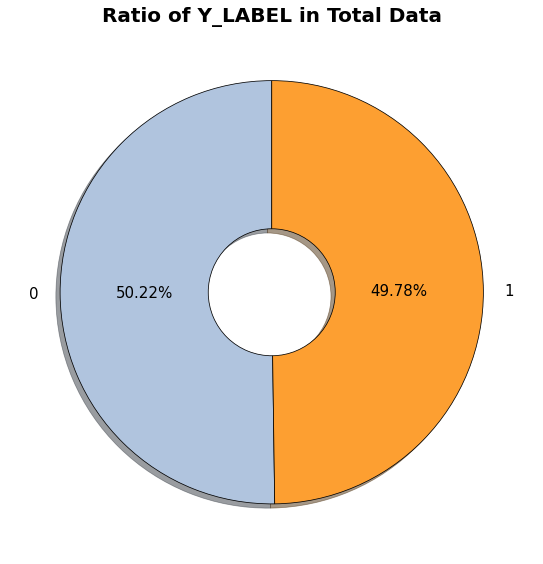

전체 데이터 수: 16574
전체 데이터 중 양품의 수:  8250
전체 데이터 중 불량품의 수:  8324


In [45]:

raw_data=pd.read_csv('/content/drive/MyDrive/oil/train.csv')
raw_data_X=raw_data.drop(['ID','COMPONENT_ARBITRARY','YEAR','Y_LABEL'],axis=1)
raw_data_y=raw_data[['Y_LABEL']]

train_X,test_X,train_y,test_y=train_test_split(raw_data_X,raw_data_y,test_size=0.2,random_state=42,stratify=raw_data_y)
train_X,val_X,train_y,val_y=train_test_split(train_X,train_y,test_size=0.2,random_state=42,stratify=train_y)
train_X=train_X.loc[:,AL_train_stage_features]
test_X_new=test_X.loc[:,test_stage_features]

min_max_scaler=MinMaxScaler() 
train_x_sc_np=min_max_scaler.fit_transform(train_X) 
train_x_sc=pd.DataFrame(train_x_sc_np,columns=train_x_sc.columns) 

val_x_sc_np=min_max_scaler.fit_transform(val_X)
val_x_sc=pd.DataFrame(val_x_sc_np,columns=val_X.columns)

test_x_sc_np=min_max_scaler.fit_transform(test_X_new)
test_x_sc=pd.DataFrame(test_x_sc_np,columns=test_X_new.columns)

adasyn=ADASYN(random_state=42)

x_adasyn,y_adasyn=adasyn.fit_resample(train_x_sc,train_y)

y_label_count(y_adasyn)

In [46]:
lgbm=LGBMC(max_depth=10, n_estimators=700, num_leaves=1600, subsample=0.8, random_state=42) 
lgbm.fit(x_adasyn,y_adasyn)

LGBMClassifier(max_depth=10, n_estimators=700, num_leaves=1600, random_state=42,
               subsample=0.8)

In [47]:
train_new_probab=pd.DataFrame()
train_new_probab['Prob']=lgbm.predict_proba(x_adasyn)[:,1]

* Student Model LigthGBMRegressor 모델 만들기

In [48]:
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1,random_state=42)

In [49]:
val_prob=pd.DataFrame()
train_new_x_sc=x_adasyn.loc[:,test_stage_features]
val_new_x_sc=val_x_sc.loc[:,test_stage_features]
lgbm_reg.fit(train_new_x_sc, train_new_probab['Prob'])
val_prob['Prob_case4']=lgbm_reg.predict(val_new_x_sc)

In [50]:
thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for threshold in thresholds:
  get_clf_eval(val_y['Y_LABEL'],val_prob['Prob_case4'],threshold)

임계값:  0.3
오차행렬
[[ 335 1729]
 [  21  171]]
정확도: 0.2243, 정밀도: 0.0900, 재현율: 0.8906, F1:0.2202
임계값:  0.35
오차행렬
[[ 492 1572]
 [  27  165]]
정확도: 0.2912, 정밀도: 0.0950, 재현율: 0.8594, F1:0.2760
임계값:  0.4
오차행렬
[[ 694 1370]
 [  41  151]]
정확도: 0.3746, 정밀도: 0.0993, 재현율: 0.7865, F1:0.3361
임계값:  0.45
오차행렬
[[ 924 1140]
 [  60  132]]
정확도: 0.4681, 정밀도: 0.1038, 재현율: 0.6875, F1:0.3933
임계값:  0.5
오차행렬
[[1169  895]
 [  92  100]]
정확도: 0.5625, 정밀도: 0.1005, 재현율: 0.5208, F1:0.4358
임계값:  0.55
오차행렬
[[1411  653]
 [ 126   66]]
정확도: 0.6547, 정밀도: 0.0918, 재현율: 0.3438, F1:0.4643
임계값:  0.6
오차행렬
[[1634  430]
 [ 142   50]]
정확도: 0.7465, 정밀도: 0.1042, 재현율: 0.2604, F1:0.4999


## TEST

In [51]:
test_prob=pd.DataFrame()

test_prob['Case4']=lgbm_reg.predict(test_x_sc)
for threshold in thresholds:
  get_clf_eval(test_y['Y_LABEL'],test_prob['Case4'],threshold)

임계값:  0.3
오차행렬
[[ 354 2224]
 [  34  207]]
정확도: 0.1990, 정밀도: 0.0852, 재현율: 0.8589, F1:0.1968
임계값:  0.35
오차행렬
[[ 501 2077]
 [  50  191]]
정확도: 0.2455, 정밀도: 0.0842, 재현율: 0.7925, F1:0.2362
임계값:  0.4
오차행렬
[[ 672 1906]
 [  64  177]]
정확도: 0.3012, 정밀도: 0.0850, 재현율: 0.7344, F1:0.2789
임계값:  0.45
오차행렬
[[ 902 1676]
 [  83  158]]
정확도: 0.3760, 정밀도: 0.0862, 재현율: 0.6556, F1:0.3293
임계값:  0.5
오차행렬
[[1160 1418]
 [ 103  138]]
정확도: 0.4604, 정밀도: 0.0887, 재현율: 0.5726, F1:0.3788
임계값:  0.55
오차행렬
[[1459 1119]
 [ 129  112]]
정확도: 0.5573, 정밀도: 0.0910, 재현율: 0.4647, F1:0.4263
임계값:  0.6
오차행렬
[[1731  847]
 [ 154   87]]
정확도: 0.6449, 정밀도: 0.0931, 재현율: 0.3610, F1:0.4619


## Class 5

* Teacher Model LightGBMClassifier 모델 만들기
* Class Imbalance 문제를 해결하기 위해 LightGBMClassifier 모델에 Randomundersampling기법을 적용하였다.

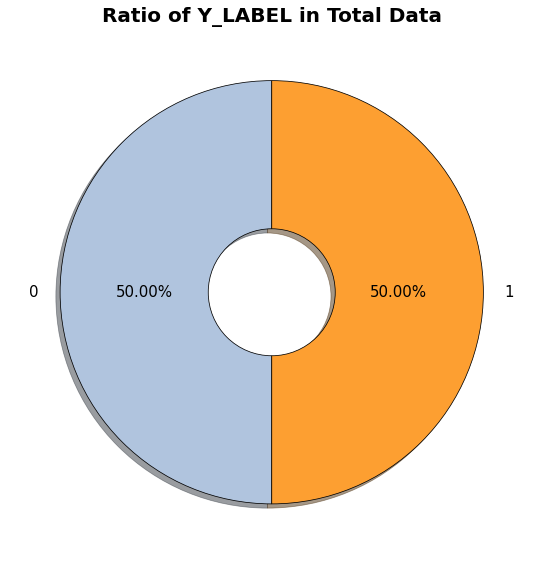

전체 데이터 수: 1540
전체 데이터 중 양품의 수:  770
전체 데이터 중 불량품의 수:  770


In [53]:
raw_data=pd.read_csv('/content/drive/MyDrive/oil/train.csv')
raw_data_X=raw_data.drop(['ID','COMPONENT_ARBITRARY','YEAR','Y_LABEL'],axis=1)
raw_data_y=raw_data[['Y_LABEL']]

train_X,test_X,train_y,test_y=train_test_split(raw_data_X,raw_data_y,test_size=0.2,random_state=42,stratify=raw_data_y)
train_X,val_X,train_y,val_y=train_test_split(train_X,train_y,test_size=0.2,random_state=42,stratify=train_y)
train_X=train_X.loc[:,AL_train_stage_features]
test_X_new=test_X.loc[:,test_stage_features]

min_max_scaler=MinMaxScaler() 
train_x_sc_np=min_max_scaler.fit_transform(train_X) 
train_x_sc=pd.DataFrame(train_x_sc_np,columns=train_x_sc.columns) 

val_x_sc_np=min_max_scaler.fit_transform(val_X)
val_x_sc=pd.DataFrame(val_x_sc_np,columns=val_X.columns)

test_x_sc_np=min_max_scaler.fit_transform(test_X_new)
test_x_sc=pd.DataFrame(test_x_sc_np,columns=test_X_new.columns)

randomunder=RandomUnderSampler(random_state=42)

x_randomunder,y_randomunder=randomunder.fit_resample(train_x_sc,train_y)

y_label_count(y_randomunder)

In [54]:
lgbm=LGBMC(max_depth=10, n_estimators=700, num_leaves=1600, subsample=0.8, random_state=42) 
lgbm.fit(x_randomunder,y_randomunder)

LGBMClassifier(max_depth=10, n_estimators=700, num_leaves=1600, random_state=42,
               subsample=0.8)

In [55]:
train_new_probab=pd.DataFrame()
train_new_probab['Prob']=lgbm.predict_proba(x_randomunder)[:,1]

* Student Model LigthGBMRegressor 모델 만들기

In [56]:
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1,random_state=42)

In [57]:
val_prob=pd.DataFrame()
train_new_x_sc=x_randomunder.loc[:,test_stage_features]
val_new_x_sc=val_x_sc.loc[:,test_stage_features]
lgbm_reg.fit(train_new_x_sc, train_new_probab['Prob'])
val_prob['Prob_case5']=lgbm_reg.predict(val_new_x_sc)

In [58]:
thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for threshold in thresholds:
  get_clf_eval(val_y['Y_LABEL'],val_prob['Prob_case5'],threshold)

임계값:  0.3
오차행렬
[[  41 2023]
 [   4  188]]
정확도: 0.1015, 정밀도: 0.0850, 재현율: 0.9792, F1:0.0977
임계값:  0.35
오차행렬
[[  76 1988]
 [   4  188]]
정확도: 0.1170, 정밀도: 0.0864, 재현율: 0.9792, F1:0.1148
임계값:  0.4
오차행렬
[[ 126 1938]
 [   5  187]]
정확도: 0.1387, 정밀도: 0.0880, 재현율: 0.9740, F1:0.1381
임계값:  0.45
오차행렬
[[ 213 1851]
 [  12  180]]
정확도: 0.1742, 정밀도: 0.0886, 재현율: 0.9375, F1:0.1740
임계값:  0.5
오차행렬
[[ 316 1748]
 [  18  174]]
정확도: 0.2172, 정밀도: 0.0905, 재현율: 0.9062, F1:0.2141
임계값:  0.55
오차행렬
[[ 437 1627]
 [  25  167]]
정확도: 0.2677, 정밀도: 0.0931, 재현율: 0.8698, F1:0.2571
임계값:  0.6
오차행렬
[[ 568 1496]
 [  30  162]]
정확도: 0.3236, 정밀도: 0.0977, 재현율: 0.8438, F1:0.3009


## TEST

In [59]:
test_prob=pd.DataFrame()

test_prob['Case5']=lgbm_reg.predict(test_x_sc)
for threshold in thresholds:
  get_clf_eval(test_y['Y_LABEL'],test_prob['Case5'],threshold)

임계값:  0.3
오차행렬
[[  43 2535]
 [   2  239]]
정확도: 0.1000, 정밀도: 0.0862, 재현율: 0.9917, F1:0.0957
임계값:  0.35
오차행렬
[[  77 2501]
 [   4  237]]
정확도: 0.1114, 정밀도: 0.0866, 재현율: 0.9834, F1:0.1085
임계값:  0.4
오차행렬
[[ 126 2452]
 [   6  235]]
정확도: 0.1281, 정밀도: 0.0875, 재현율: 0.9751, F1:0.1268
임계값:  0.45
오차행렬
[[ 191 2387]
 [   8  233]]
정확도: 0.1504, 정밀도: 0.0889, 재현율: 0.9668, F1:0.1502
임계값:  0.5
오차행렬
[[ 283 2295]
 [  12  229]]
정확도: 0.1816, 정밀도: 0.0907, 재현율: 0.9502, F1:0.1813
임계값:  0.55
오차행렬
[[ 407 2171]
 [  19  222]]
정확도: 0.2231, 정밀도: 0.0928, 재현율: 0.9212, F1:0.2198
임계값:  0.6
오차행렬
[[ 556 2022]
 [  34  207]]
정확도: 0.2707, 정밀도: 0.0929, 재현율: 0.8589, F1:0.2593


## 정리

* Validation Data - 각 Case 별 임계값에 따른 Macro F-1 Score 결과는 아래와 같음.

| |Scale|Sampling|0.3|0.35|0.40|0.45|0.5|0.55|0.6|\
|:-------:|:-------:|:--------:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|Case 1| Min-Max Scaler | class weight |0.5211|0.5236|0.5165|0.4952|0.4911|0.4947|0.4911|
|Case 2| Min-Max Scaler | SMOTE |0.1942|0.2422|0.2909|0.3437|0.3914|0.4341|0.4831|
|Case 3| Min-Max Scaler | SMOTE-Tomek|0.2191|0.2598|0.3115|0.3573|0.4067|0.4497|0.4951|
|Case 4| Min-Max Scaler | ADASYN|0.2202|0.2760|0.3361|0.3933|0.4358|0.4643|0.4999|
|Case 5| Min-Max Scaler | RandomUndersampling|0.0977|0.1148|0.1381|0.1740|0.2141|0.2571|0.3009|



* Test Data - 각 Case 별 임계값에 따른 Macro F-1 Score 결과는 아래와 같음.

| |Scale|Sampling|0.3|0.35|0.40|0.45|0.5|0.55|0.6|\
|:-------:|:-------:|:--------:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|Case 1| Min-Max Scaler | class weight |0.5418|0.5186|0.4977|0.4900|0.4825|0.4841|0.4769|
|Case 2| Min-Max Scaler | SMOTE |0.1652|0.1987|0.2363|0.2779|0.3301|0.3738|0.4177|
|Case 3| Min-Max Scaler | SMOTE-Tomek|0.1713|0.2050|0.2410|0.2862|0.3354|0.3806|0.4291|
|Case 4| Min-Max Scaler | ADASYN|0.1968|0.2362|0.2789|0.3293|0.3788|0.4263|0.4619|
|Case 5| Min-Max Scaler | RandomUndersampling|0.0957|0.1085|0.1268|0.1502|0.1813|0.2198|0.2593|

* 샘플링 기법을 적용하지 않고 Class weight만 적용한 것이 가장 효과적이었다. 
* Validation data에서는 임계값이 0.35이고 Class weight만 적용했을 때 Macro F-1 Score가 가장 높았고 Test data에서는 임계값이 0.3이고 Class weight만 적용했을 때가 Macro F-1 Score가 가장 높았다.